### **모델링을 시작합니다.**

Feature Engineering 등의 3차 전처리는 모델링과 함께 진행하며, 모델 성능을 높일 예정입니다.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline

In [ ]:
# 랜덤포레스트 모델링

pipe_rf = make_pipeline(
    RandomForestClassifier(n_estimators=300))

pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_val)

print(accuracy_score(y_val, pred_rf))
print(f1_score(y_val,pred_rf))
print(roc_auc_score(y_val, pred_rf))

0.5375
0.5375000000000001
0.557085020242915


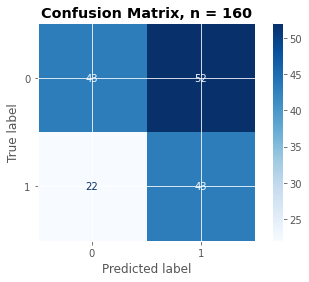

In [ ]:
# 데이터의 균형을 살펴봅니다. 데이터가 어느정도 불균형하다고 판단되면, f1-score를 사용합니다. 그것이 아니라면, accuracy를 사용합니다.
# 결과: TP, FN, FP, TN 값 중 FP값이 비교적 적습니다. 따라서, 안전하게 f1-score의 점수로 모델 성능을 평가합니다.

plt.style.use(['ggplot'])

fig, axes = plt.subplots()
pcm = plot_confusion_matrix(pipe_rf, X_val, y_val, cmap = 'Blues', ax = axes, values_format = 'd')
plt.title(f'Confusion Matrix, n = {len(y_val)}', weight = 'bold')

plt.show();

In [ ]:
# XGB 모델링

pipe_xg = make_pipeline(
    XGBClassifier(n_estimators=300))

dists = {'xgbclassifier__learning_rate': [0.05,0.1,0.3], 'xgbclassifier__min_child_weight': range(1,10), 'xgbclassifier__max_depth':range(3,10), 'xgbclassifier__colsample_bytree':[0.5,0.7,1.0]}

clf_xgb = GridSearchCV(pipe_xg, param_grid=dists, cv=5, scoring='roc_auc')

clf_xgb.fit(X_train, y_train)
pipe_xgb = clf_xgb.best_estimator_

pipe_xgb.fit(X_train, y_train)
pred_xgb = pipe_xgb.predict(X_val)

print(accuracy_score(y_val, pred_xgb))
print(f1_score(y_val,pred_xgb))
print(roc_auc_score(y_val, pred_xgb))

0.56875
0.5490196078431372
0.5809716599190284


In [ ]:
clf_xgb.best_estimator_

Pipeline(memory=None,
         steps=[('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=300, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

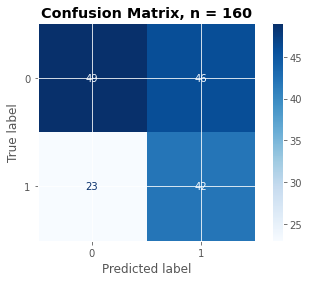

In [ ]:
# 데이터의 균형을 살펴봅니다. 데이터가 어느정도 불균형하다고 판단되면, f1-score를 사용합니다. 그것이 아니라면, accuracy를 사용합니다.

plt.style.use(['ggplot'])

fig, axes = plt.subplots()
pcm = plot_confusion_matrix(pipe_xgb, X_val, y_val, cmap = 'Blues', ax = axes, values_format = 'd')
plt.title(f'Confusion Matrix, n = {len(y_val)}', weight = 'bold')
plt.show();

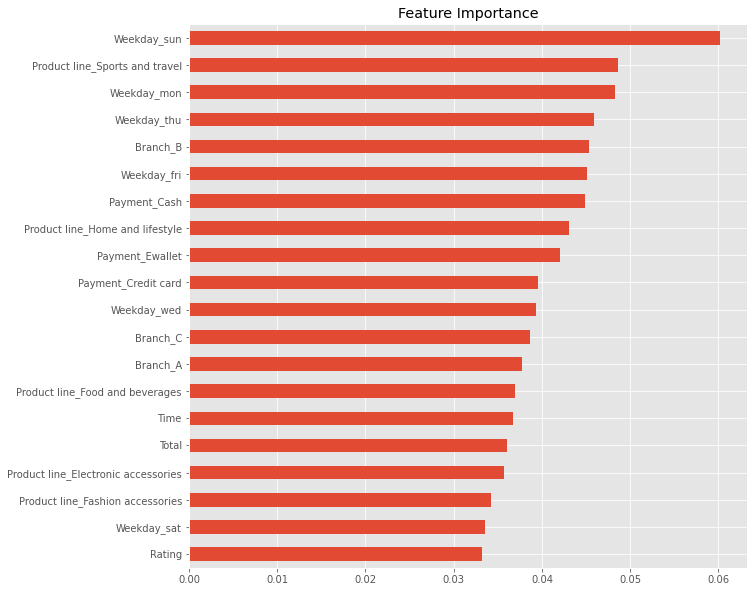

In [ ]:
# 특성 중요도를 살펴보겠습니다.

xgb = pipe_xgb.named_steps['xgbclassifier']
importances = pd.Series(xgb.feature_importances_, X_train.columns)

plt.figure(figsize=(10,10))
plt.title(f'Feature Importance')
importances.sort_values()[-20:].plot.barh();

In [ ]:
# eli5 라이브러리 기반 Feature Importance 를 산출합니다.
# https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

pip install eli5

     |████████████████████████████████| 112kB 5.6MB/s 


In [ ]:
# eli5 라이브러리 기반 Feature Importance 를 산출합니다.
# https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe_xgb.named_steps['xgbclassifier'],
    scoring='accuracy',
    n_iter=5)

permuter.fit(X_val, y_val)

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Payment_Cash                          -0.02000
Product line_Home and lifestyle       -0.01000
Product line_Health and beauty        -0.00875
Product line_Sports and travel        -0.00500
Weekday_mon                           -0.00250
Branch_B                              -0.00250
Payment_Ewallet                       -0.00125
Branch_A                              -0.00125
Customer type_Member                   0.00000
Weekday_sat                            0.00250
Customer type_Normal                   0.00250
Weekday_wed                            0.00375
Rating                                 0.00375
Product line_Electronic accessories    0.00375
Product line_Food and beverages        0.00500
Branch_C                               0.00625
Weekday_fri                            0.00625
Weekday_thu                            0.00625
Weekday_sun                            0.00750
Weekday_tue                            0.00875
Payment_Credit card                    0.01000
Quantity     

In [ ]:
# 위의 자료를 시각화합니다.

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names)

Weight,Feature
0.0400 ± 0.0322,Total
0.0262 ± 0.0166,Product line_Fashion accessories
0.0262 ± 0.0539,Unit price
0.0137 ± 0.0414,Time
0.0100 ± 0.0232,Quantity
0.0100 ± 0.0100,Payment_Credit card
0.0087 ± 0.0127,Weekday_tue
0.0075 ± 0.0050,Weekday_sun
0.0062 ± 0.0000,Weekday_thu
0.0062 ± 0.0112,Weekday_fri


In [ ]:
# 상기 중요도에서 0.0005 보다 작은 Feature값은 삭제한 후 재모델링합니다. 
# 결과: Score 약한 상승, 속도 증가로 인해 모델 성능이 향상됐습니다.

features = X_train.columns[permuter.feature_importances_ >0.001]
selec_X_train = X_train[features]
selec_X_val = X_val[features]

pipe_xgb.fit(selec_X_train,y_train)
pred_xgb = pipe_xgb.predict(selec_X_val)

print(accuracy_score(y_val, pred_xgb).round(2))
print(f1_score(y_val,pred_xgb).round(2))
print(roc_auc_score(y_val, pred_xgb).round(2))

0.6
0.56
0.6


In [ ]:
# 그래디언트부스팅 활용
# 결과: XGB 모델성능이 더 높으므로, XGB를 선택하는 것으로 결정합니다.

pipe_gb = make_pipeline(
    GradientBoostingClassifier())

dists = {'gradientboostingclassifier__learning_rate' : [0.01,0.05,1] ,'gradientboostingclassifier__loss' : ['deviance','exponential'],'gradientboostingclassifier__min_samples_leaf' : range(3,7), 'gradientboostingclassifier__max_depth' : range(3,10)}

clf_gb = GridSearchCV(pipe_gb, param_grid=dists, cv=5, scoring='roc_auc')

clf_gb.fit(X_train, y_train)
pipe_gb = clf_gb.best_estimator_

pipe_gb.fit(X_train, y_train)
pred_gb = pipe_gb.predict(X_val)

print(accuracy_score(y_val, pred_gb))
print(f1_score(y_val,pred_gb))
print(roc_auc_score(y_val, pred_gb))

0.525
0.48648648648648646
0.5295546558704454
